In [1]:
import ebf
import healpix_util as hu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import healpy as hp
import astropy.stats as st
import astropy.visualization as av

In [2]:
data = ebf.read('../GalaxiaData/sdssHalo.ebf', '/')

In [3]:
data.keys()

['rad',
 'exbv_solar',
 'teff',
 'sdss_g',
 'mag2',
 'mag1',
 'mag0',
 'sdss_r',
 'sdss_u',
 'satid',
 'vx',
 'vy',
 'vz',
 'sdss_z',
 'mtip',
 'log',
 'pz',
 'px',
 'py',
 'feh',
 'exbv_schlegel',
 'sdss_i',
 'lum',
 'exbv_schlegel_inf',
 'mact',
 'glon',
 'popid',
 'glat',
 'alpha',
 'center',
 'partid',
 'age',
 'grav',
 'smass',
 'fieldid']

In [4]:
c = coord.Galactic(u=data['px']*u.kpc, v=data['py']*u.kpc, w=data['pz']*u.kpc,
                 U=data['vx']*u.km/u.s, V=data['vy']*u.km/u.s, W=data['vz']*u.km/u.s,
                 representation=coord.CartesianRepresentation, differential_cls=coord.CartesianDifferential)
c.set_representation_cls(coord.SphericalRepresentation, s=coord.SphericalCosLatDifferential)

pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)


In [5]:
appmag = data['sdss_g'] + 5.*np.log10(data['rad']*1000./10.)
redpm = appmag + 5.*np.log10(pm.value)

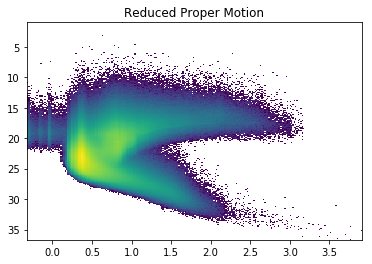

In [6]:
plt.hist2d(data['sdss_g'] - data['sdss_i'], redpm, bins=250, norm=mpl.colors.LogNorm())
plt.title('Reduced Proper Motion')
plt.gca().invert_yaxis()

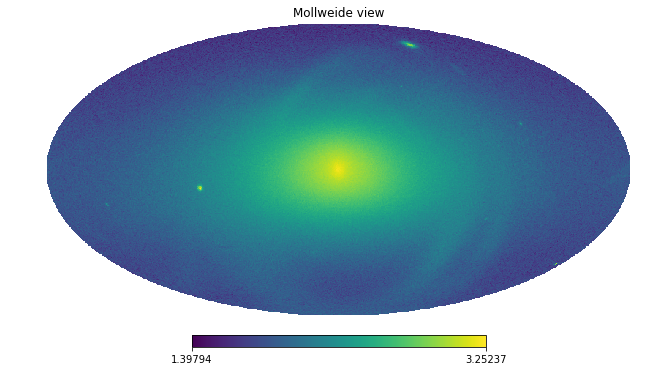

In [7]:
#for visualizing all data on the sky 
nside = 128
hpix = hu.HealPix("ring", nside)
pixnums = hpix.eq2pix(data['glon'], data['glat'])
omap = np.bincount(pixnums, minlength=hpix.npix)
mapSky = hp.mollview(np.log10(omap), return_projected_map=True)
plt.savefig('pofd_allsky.pdf')

In [8]:
#bin edges for proper motions 
bin_edges = np.array([0, 0.1, 1, 10, 100]) #np.logspace(-3, 3, 4)
#hist, bin_edges, patches = av.hist(pm, bins='blocks')
#print len(bin_edges)
pmInd = np.digitize(pm, bin_edges)
#plt.savefig('pmHistBayesBlocks.png')
nside = 2
hpix=hu.HealPix("ring", nside)
npix = hpix.npix
pixnums = hpix.eq2pix(data['glon'], data['glat'])

Text(0.5,1,u'sdss g apparent magnitude')

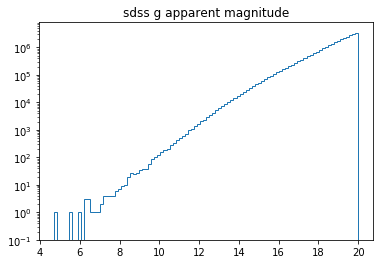

In [9]:
plt.hist(appmag, bins=100, histtype='step', log=True)
plt.title('sdss g apparent magnitude')

In [10]:
bin_edges = np.array([10, 15])
appmagInd = np.digitize(appmag, bin_edges)

In [11]:
xbin = 0.5*(bin_edges[1:] + bin_edges[:-1])
#plt.plot(xbin, hist, )

Text(0.5,1,u'Number of stars in each pixel')

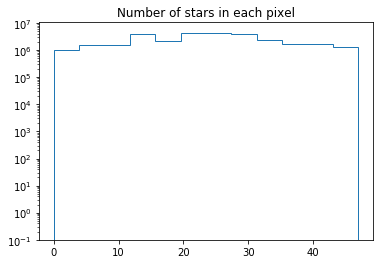

In [12]:
plt.clf()
plt.hist(pixnums, bins=12, log=True, histtype='step')
plt.title('Number of stars in each pixel')

Text(0,0.5,u'histogram')

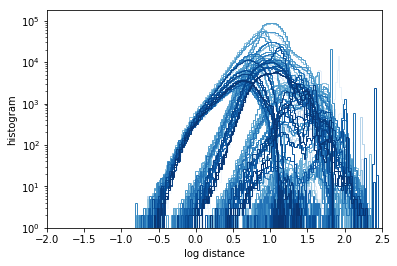

In [13]:
#color cooresponds to a given pixel
#the stars are binned up by pixel and proper motion
color=iter(plt.cm.Blues(np.linspace(0,1,48)))

for pix in range(np.max(pixnums)): 
    c=next(color)
    for pmi in range(np.max(pmInd)):

        plt.hist(np.log10(data['rad'][(pixnums == pix) & (pmInd == pmi)]), bins=100, log=True, histtype='step', color=c)
#plt.legend()
plt.xlim(-2, 2.5)
plt.ylim(1,)
plt.xlabel('log distance')
plt.ylabel('histogram')

Text(0,0.5,u'histogram')

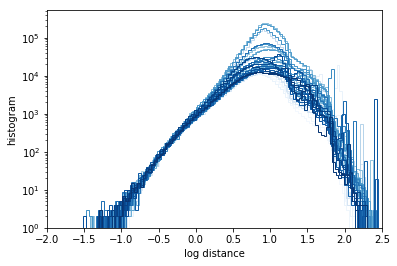

In [14]:
color=iter(plt.cm.Blues(np.linspace(0,1,48)))

for pix in range(np.max(pixnums)): 
        c=next(color)
        plt.hist(np.log10(data['rad'][(pixnums == pix)]), bins=100, log=True, histtype='step', color=c)
#plt.legend()
plt.xlim(-2, 2.5)
plt.ylim(1,)
plt.xlabel('log distance')
plt.ylabel('histogram')

  0: Thin Disk  < 0.15    Gyr
  1: Thin Disk     0.15-1 Gyr
  2: Thin Disk     1-2      Gyr 
  3: Thin Disk     2-3      Gyr
  4: Thin Disk     3-5      Gyr
  5: Thin Disk     5-7      Gyr
  6: Thin Disk     7-10    Gyr
  7: Thick Disk 
  8: Stellar Halo
  9: Bulge

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


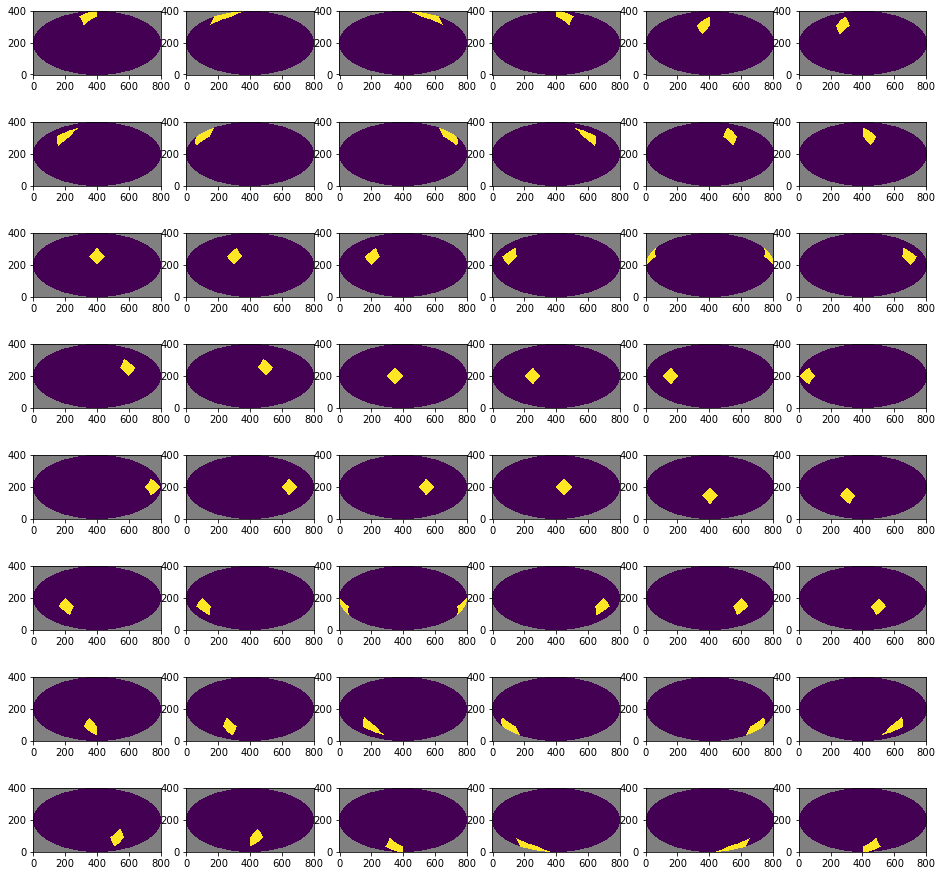

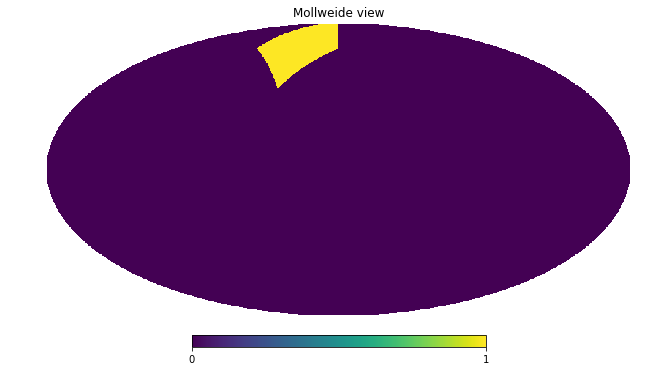

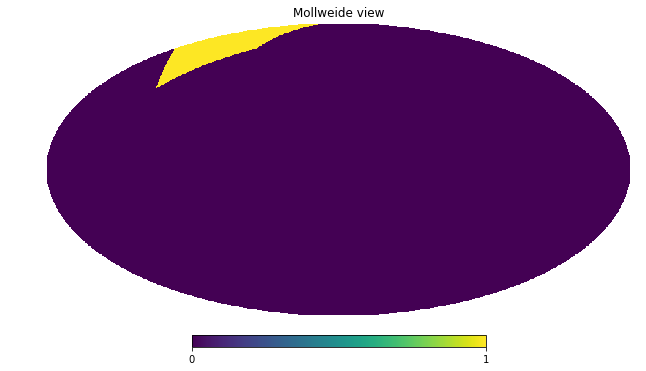

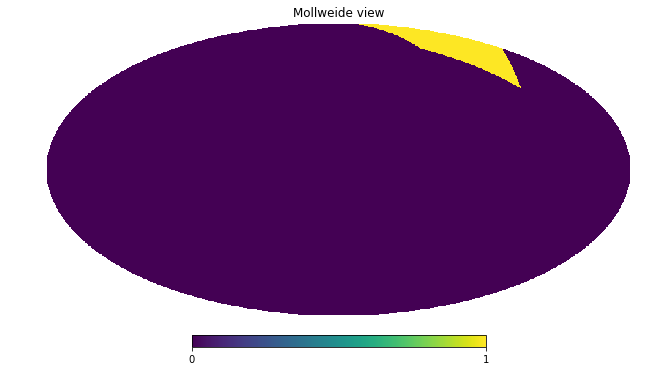

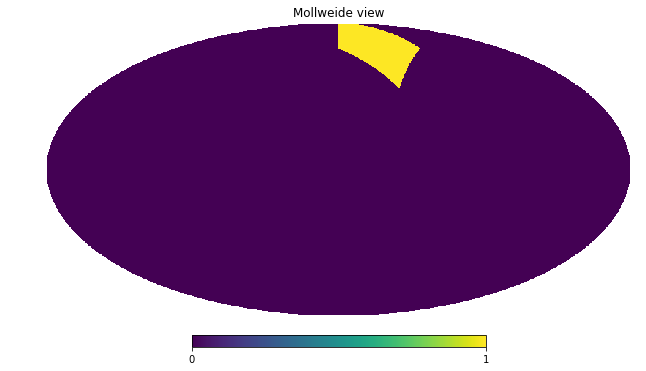

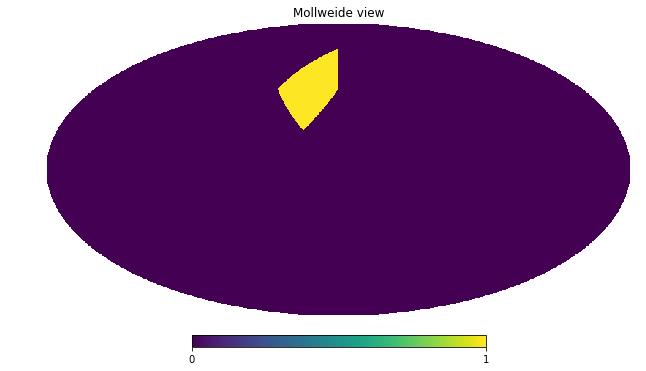

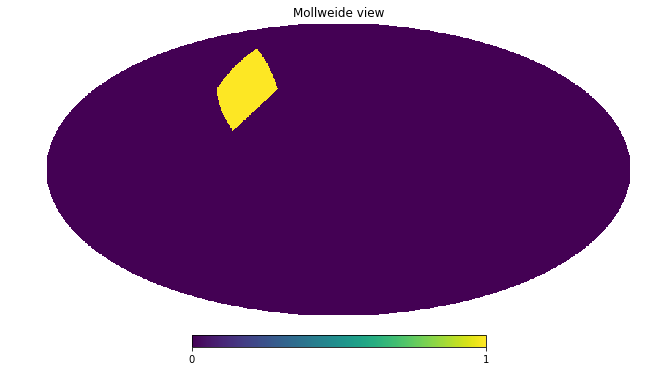

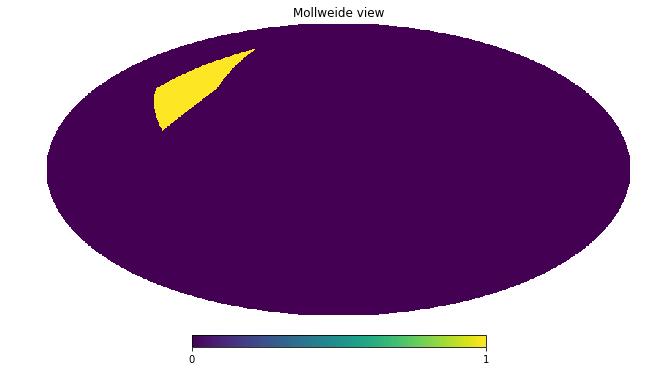

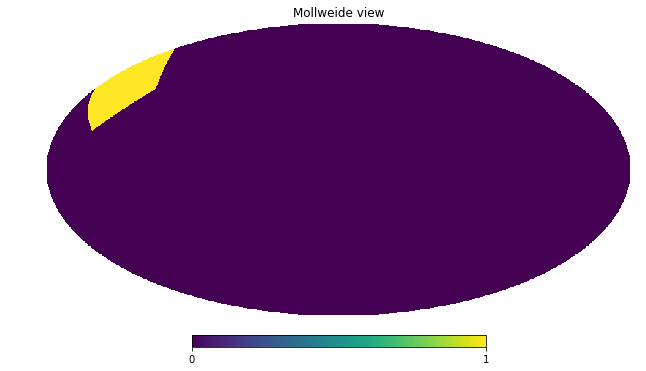

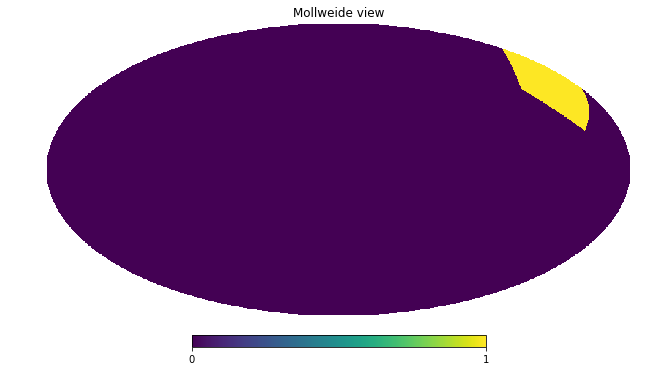

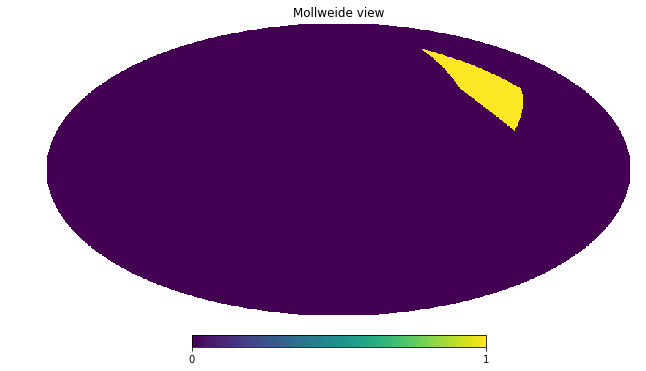

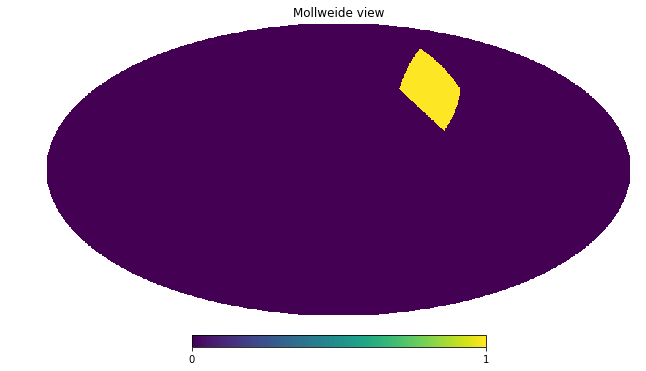

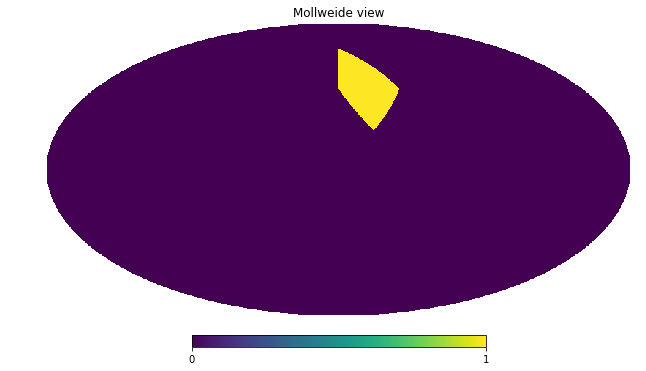

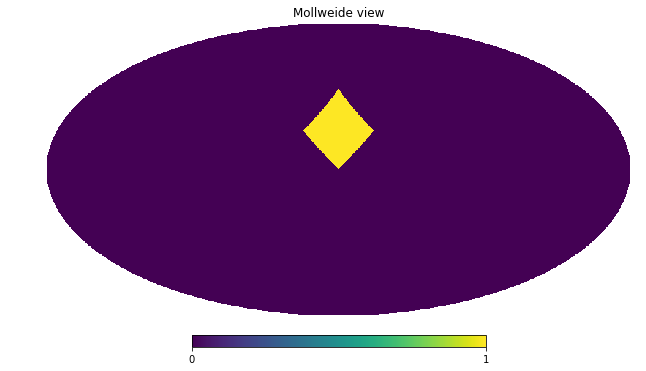

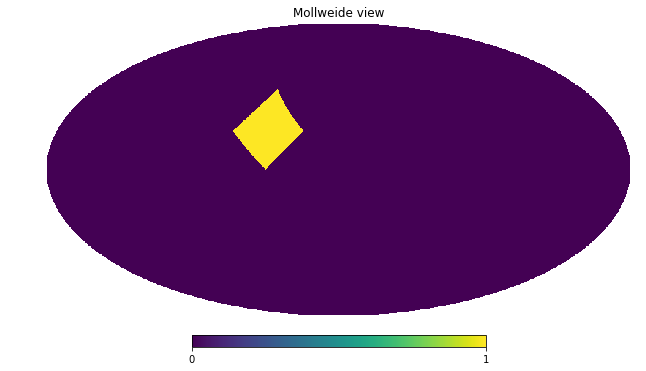

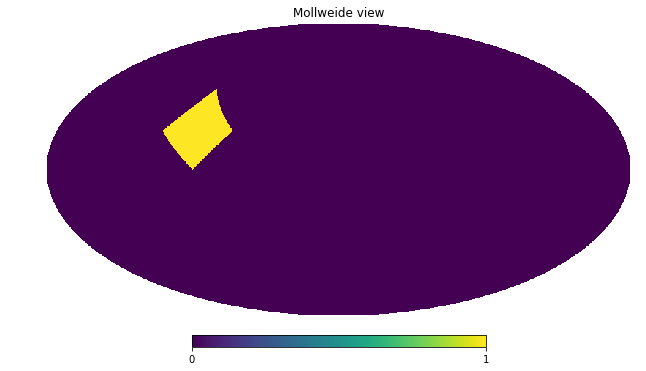

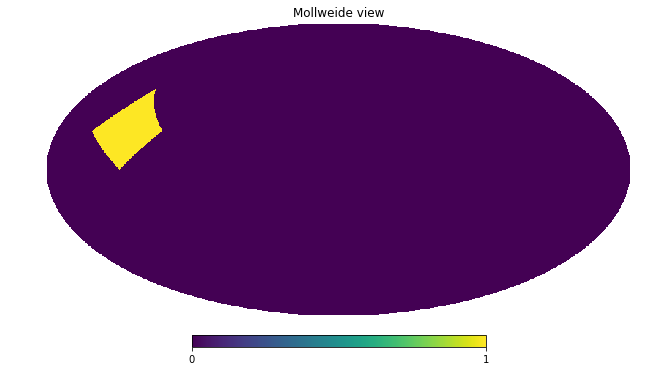

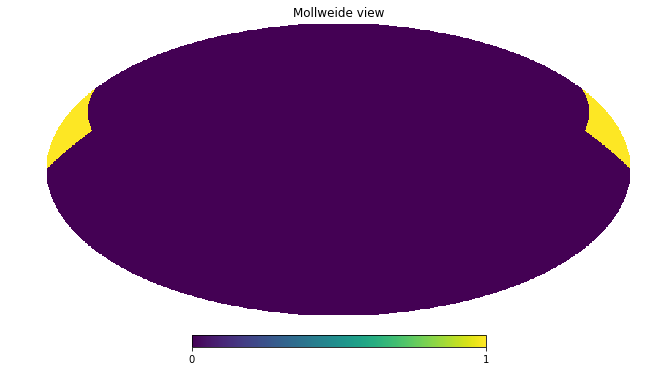

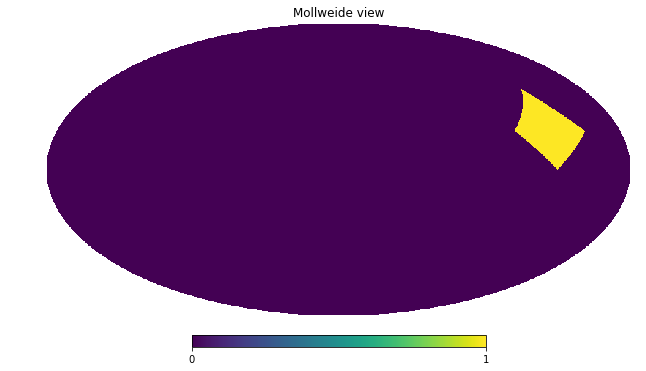

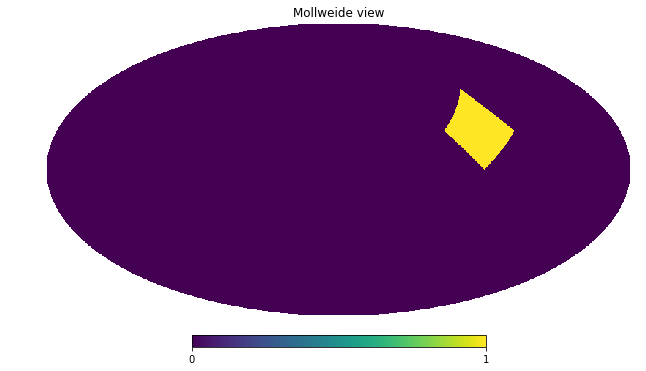

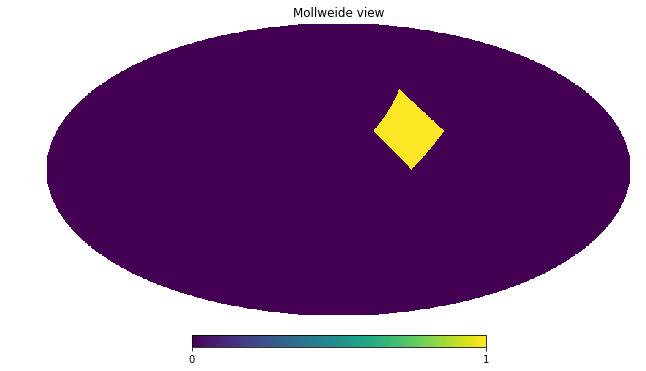

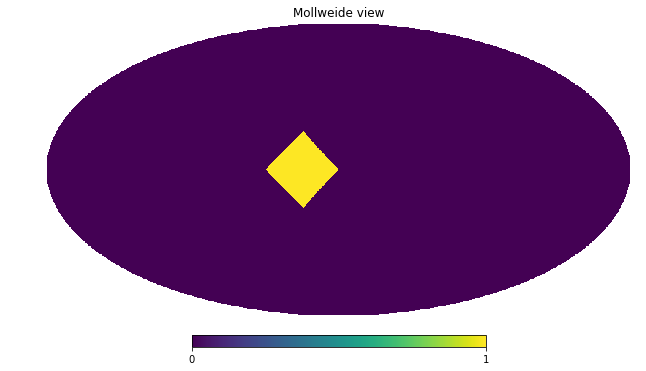

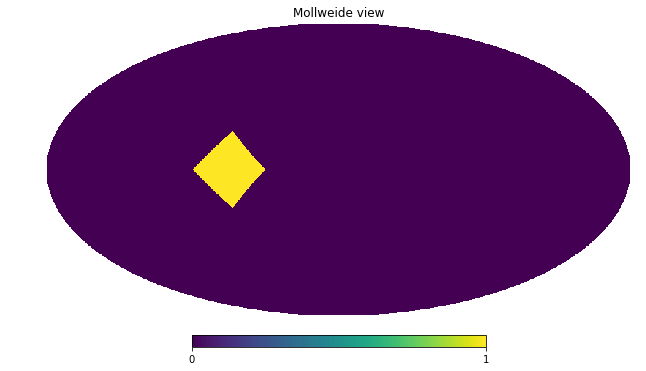

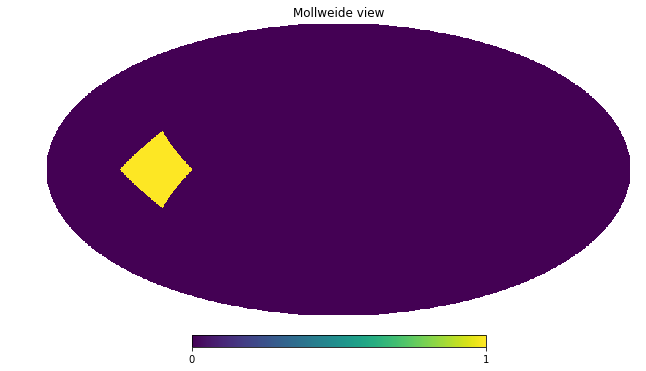

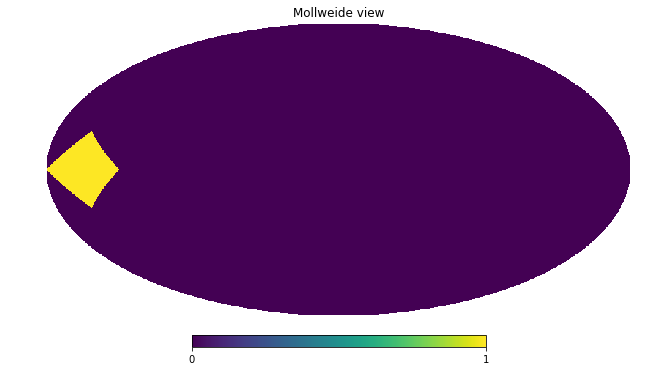

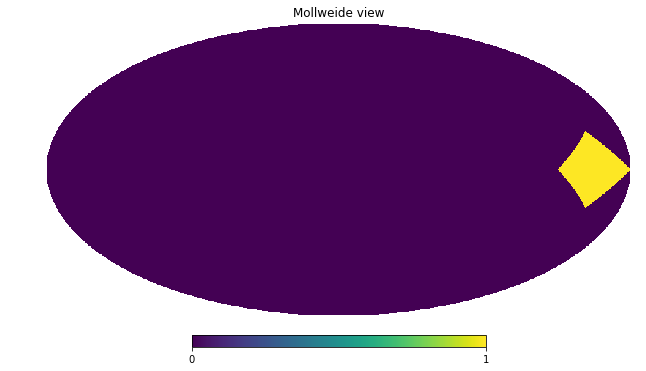

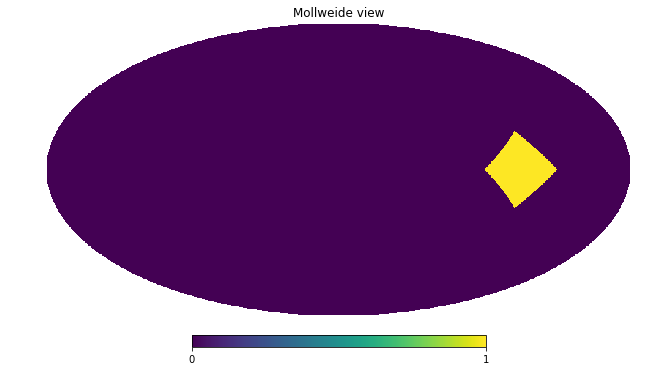

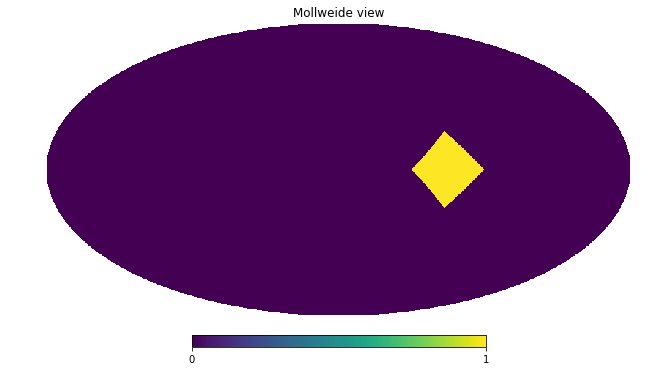

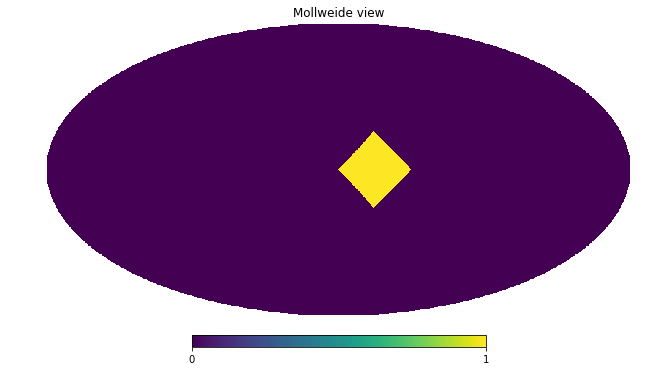

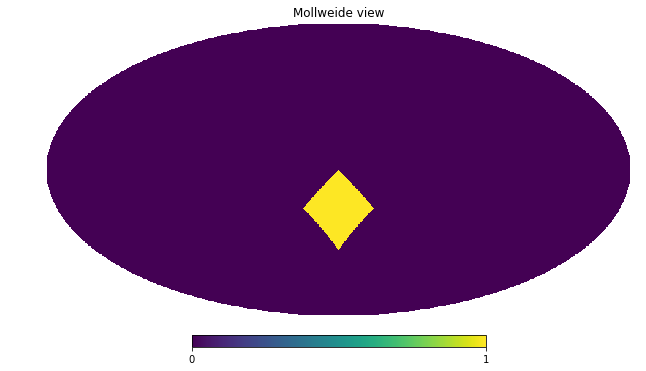

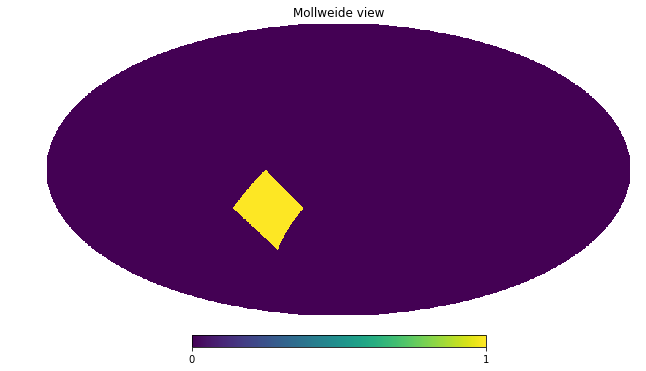

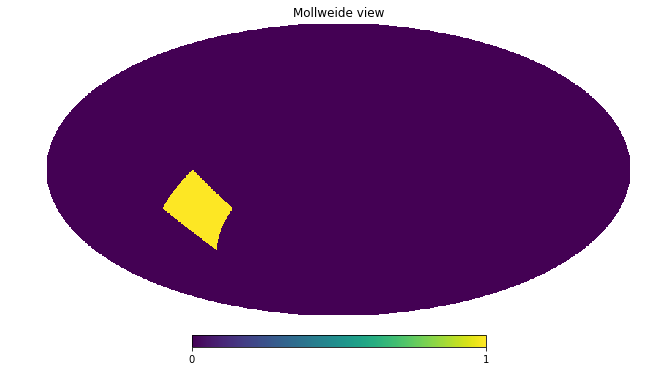

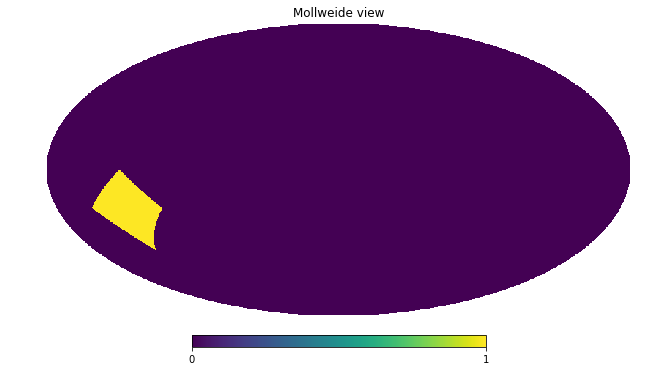

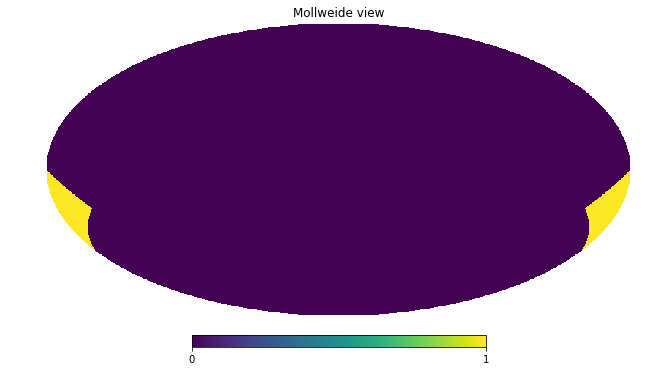

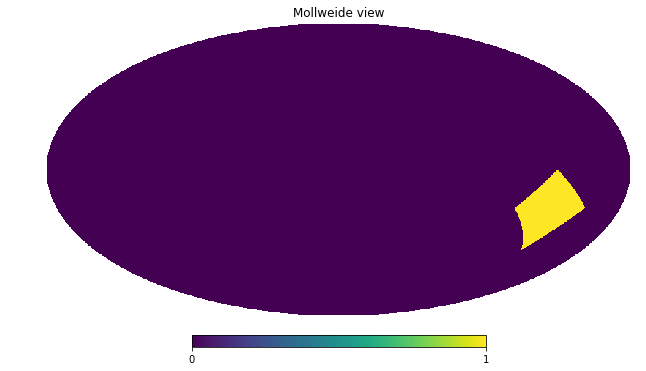

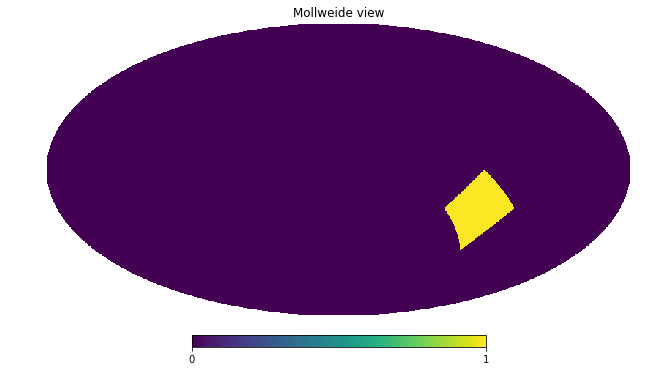

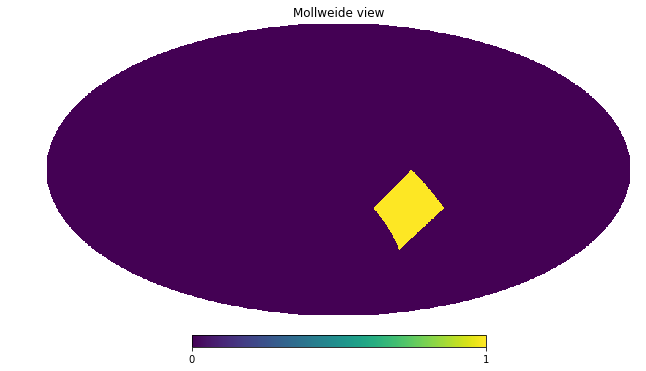

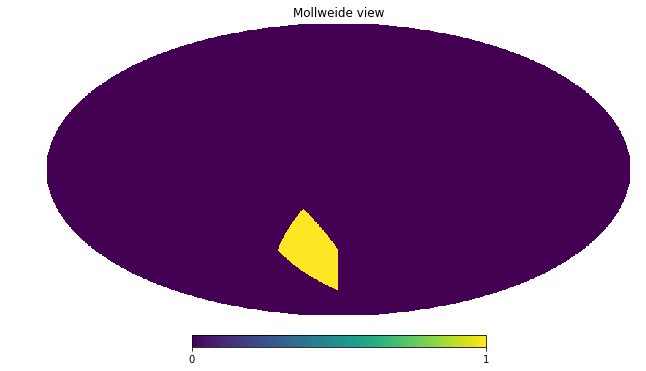

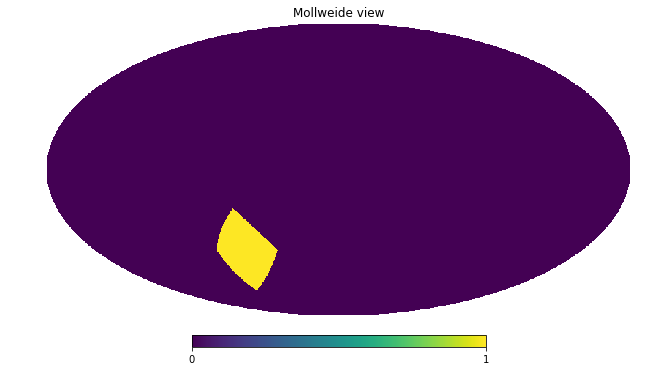

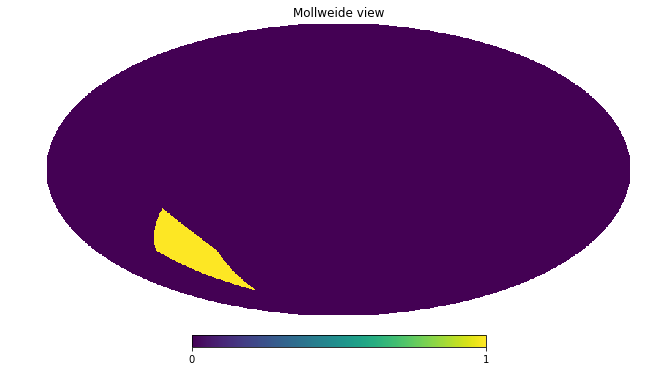

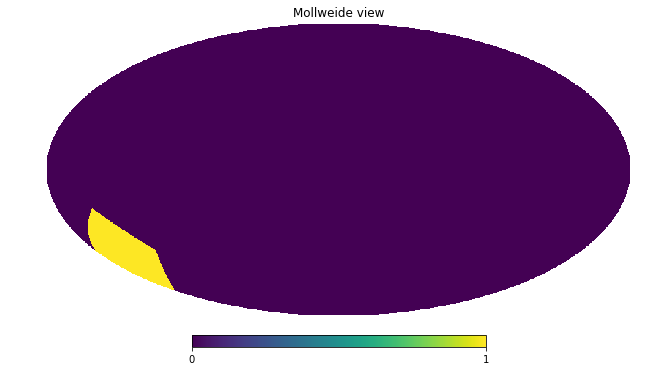

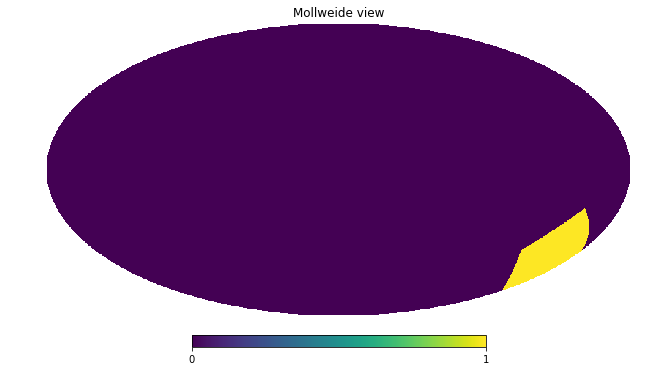

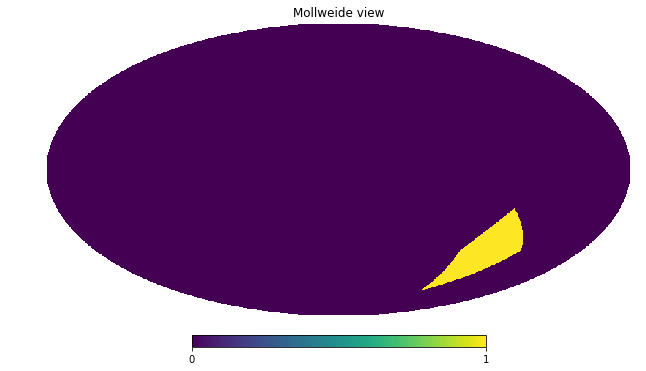

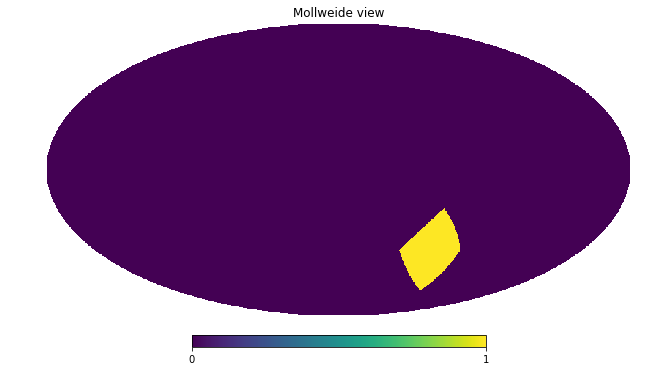

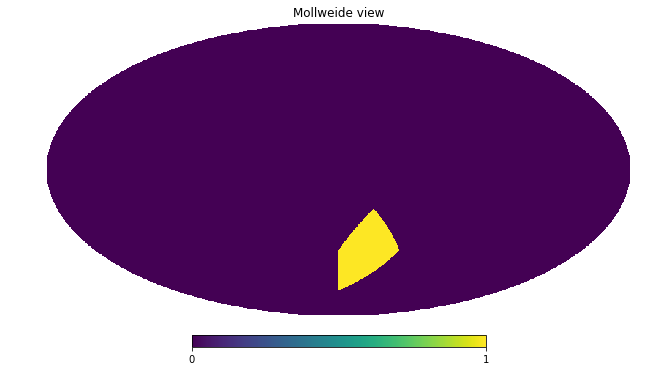

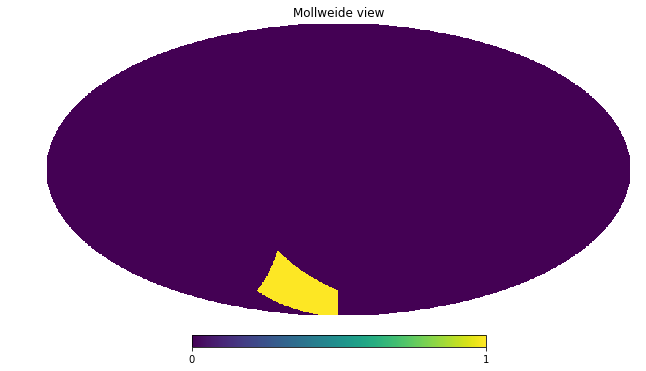

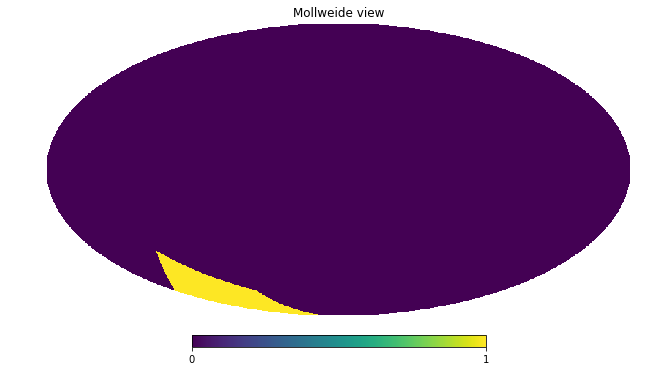

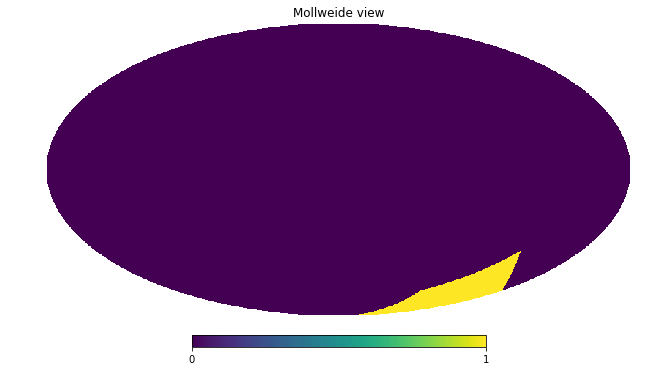

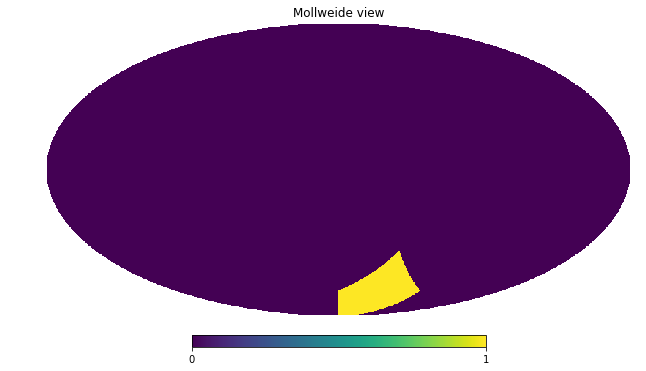

In [15]:
fig, axes = plt.subplots(4*nside, 3*nside, figsize=(8*nside, 8*nside))
axes = axes.flatten()
npix = hpix.npix # hp.nside2npix(nside)
for i in range(npix):
    mask = np.zeros(npix)
    mask[i] = 1.0
    map = hp.mollview(mask, return_projected_map=True)
    axes[i].imshow(map, origin='lower')
fig.savefig('pofd_sky.pdf')
plt.close(fig)

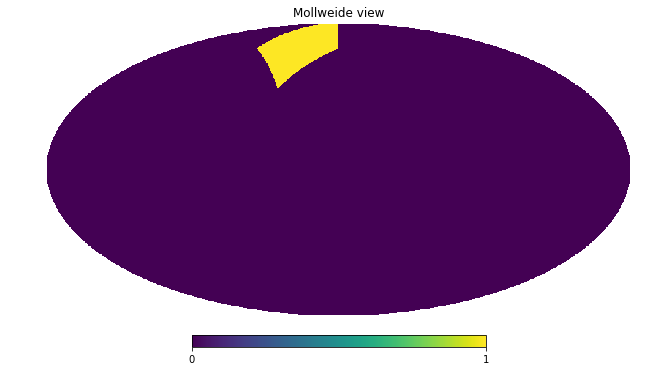

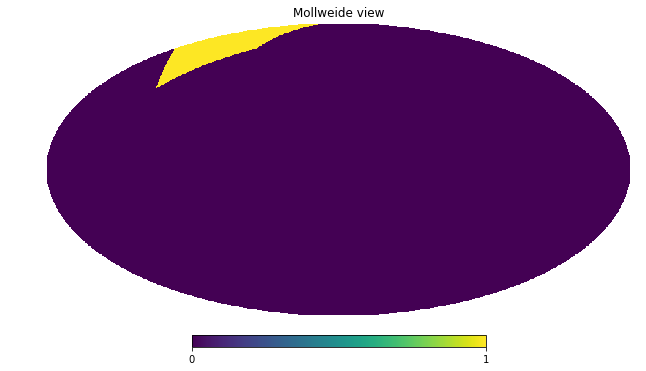

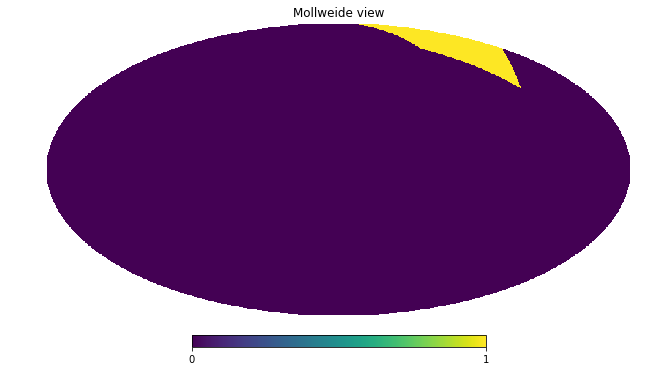

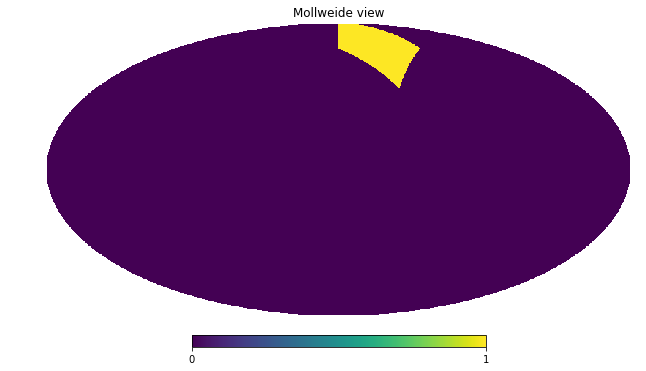

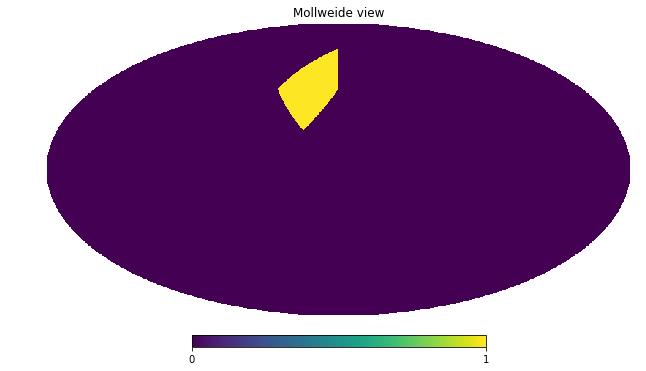

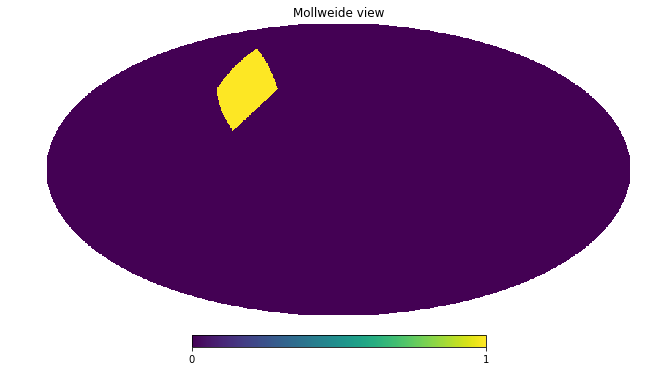

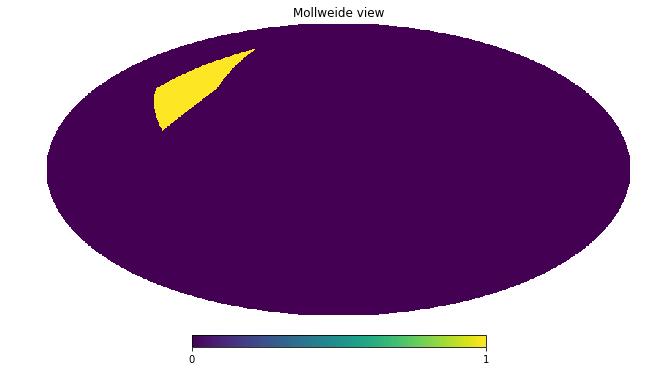

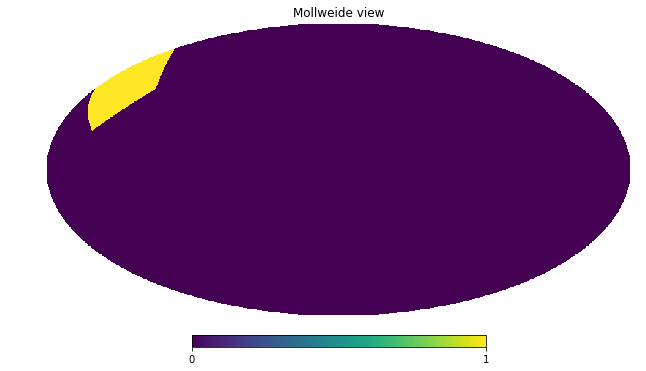

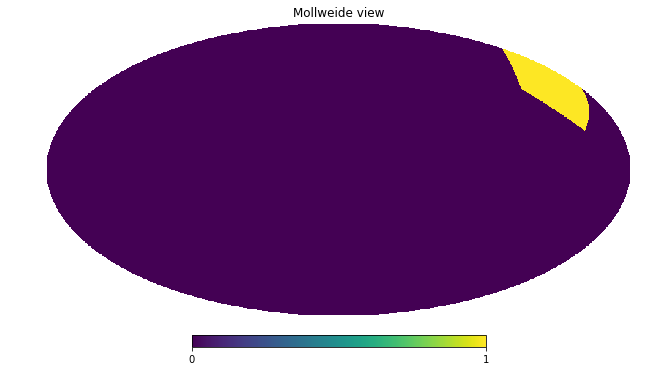

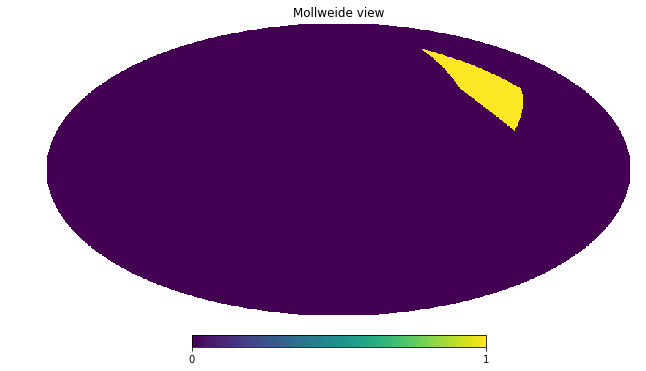

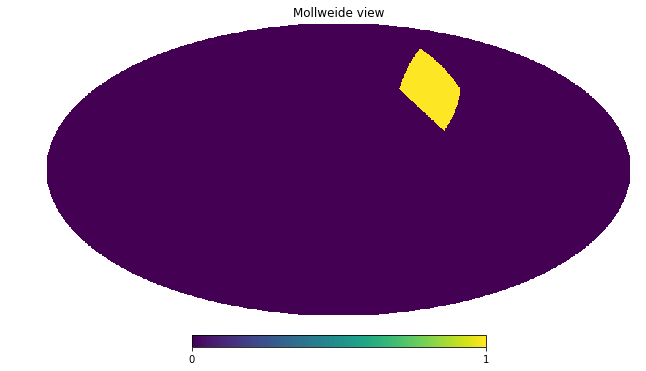

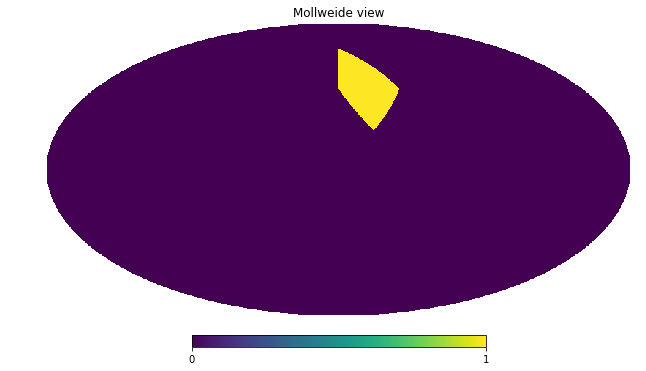

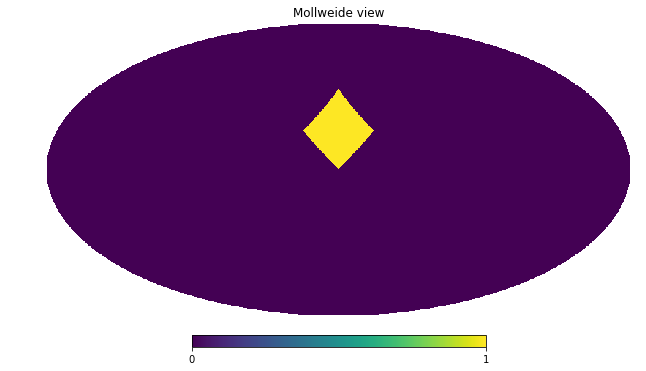

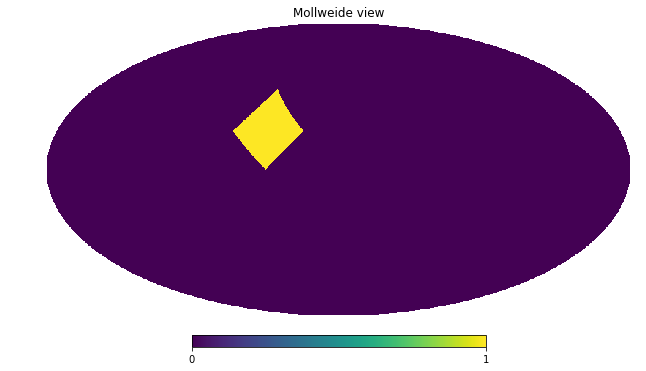

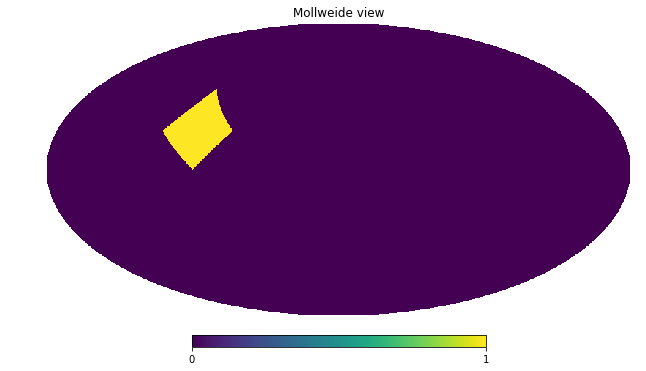

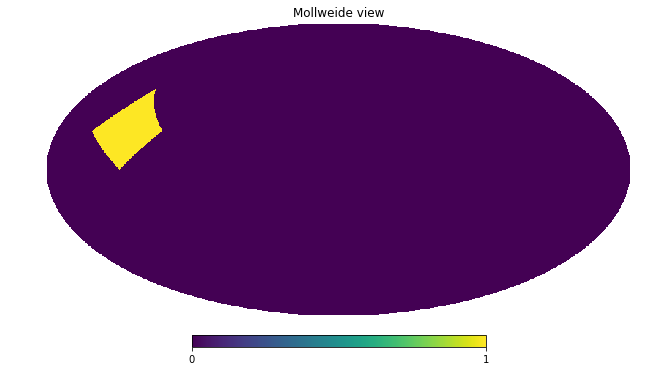

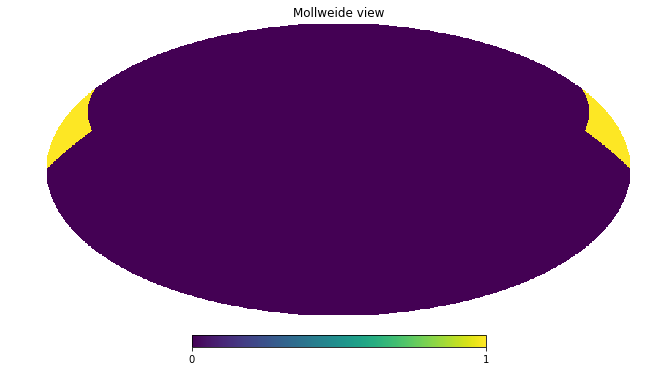

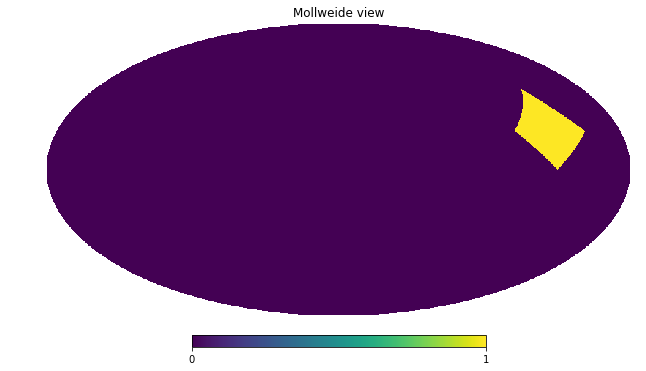

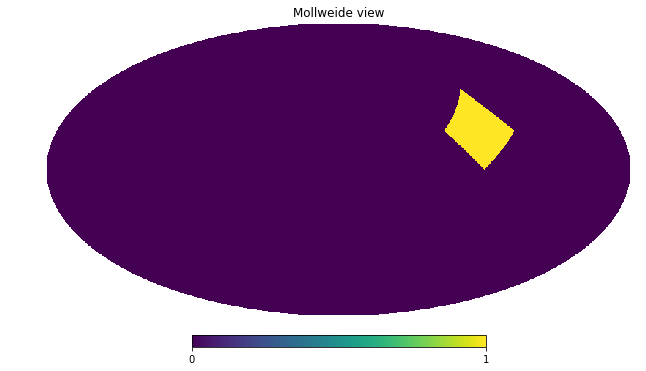

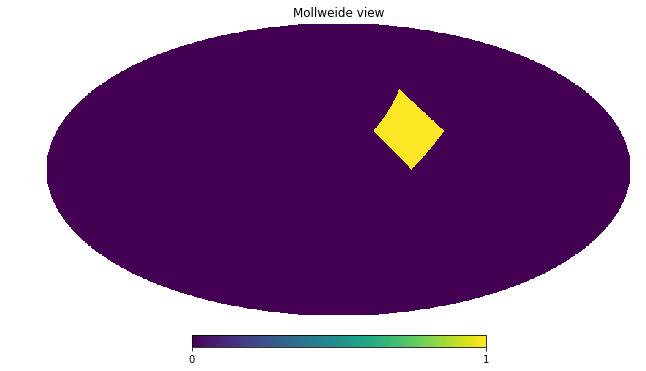

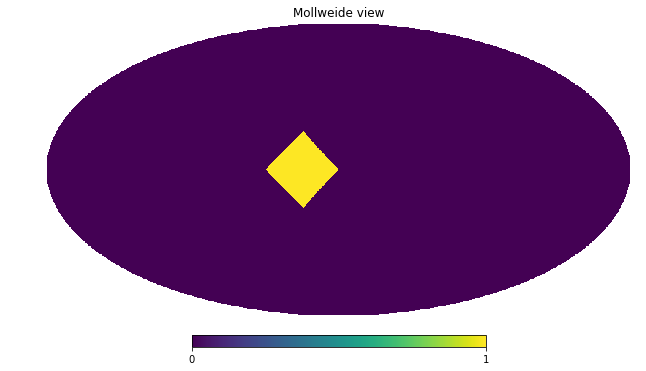

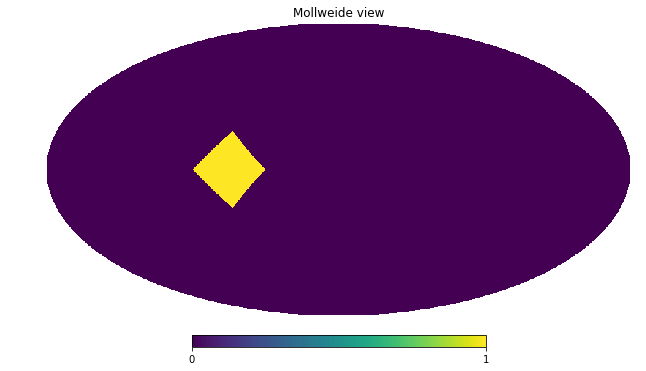

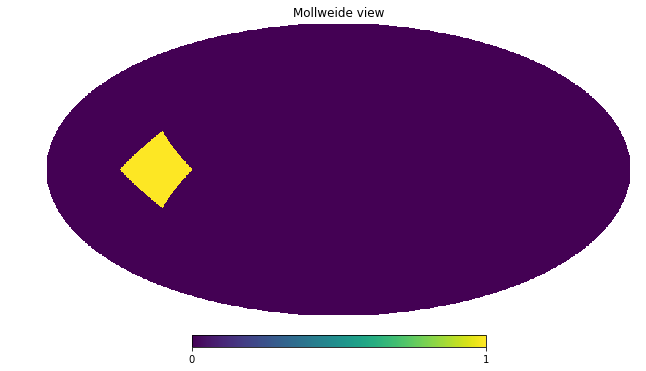

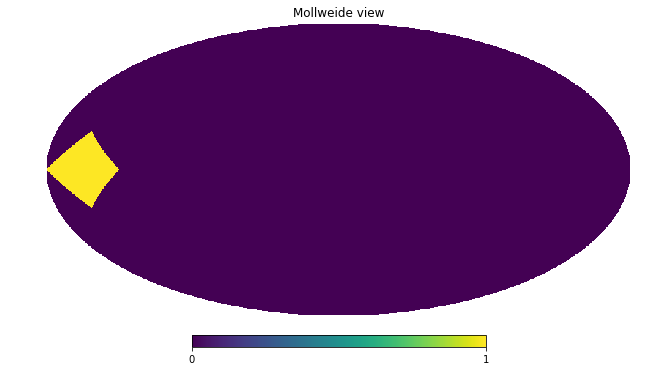

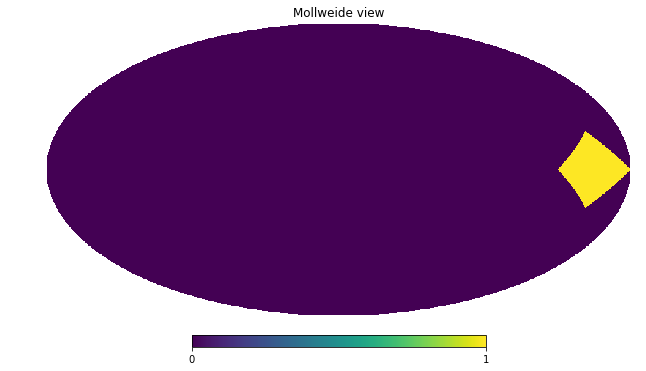

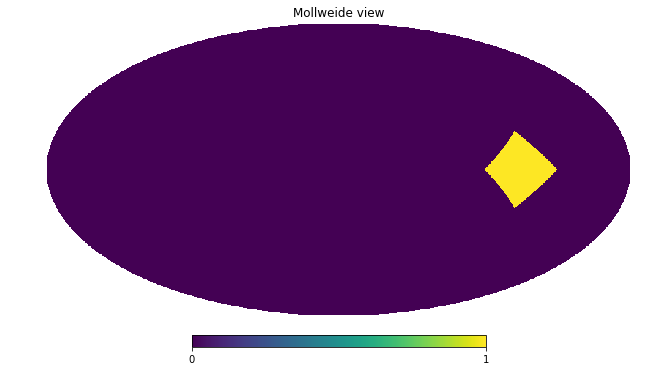

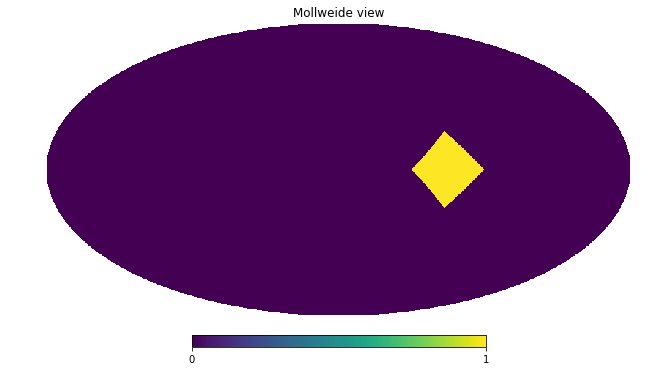

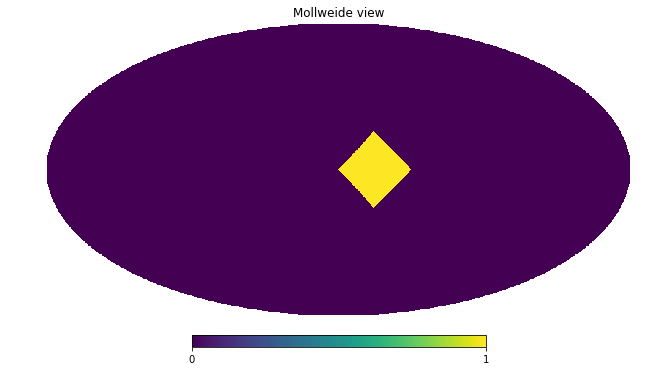

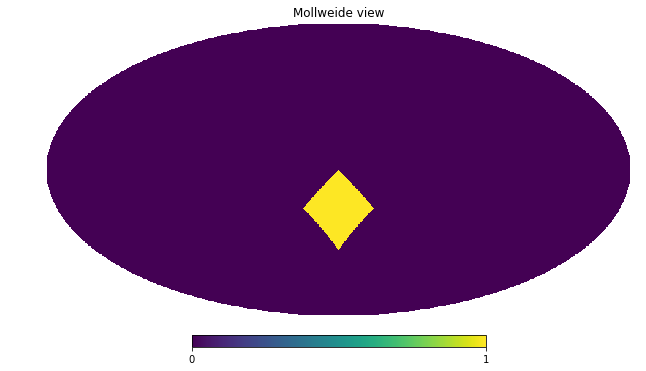

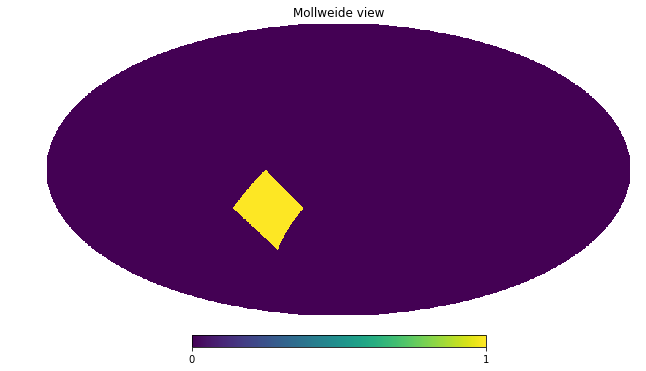

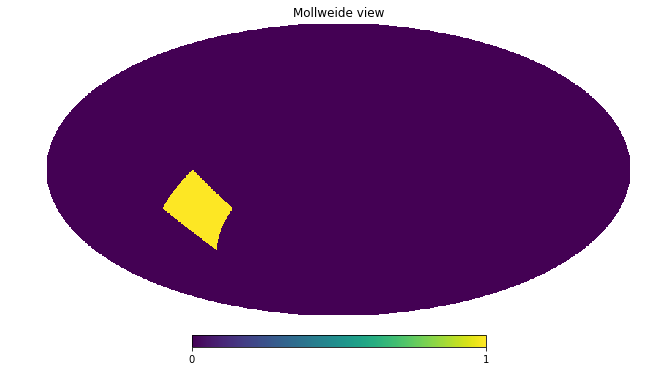

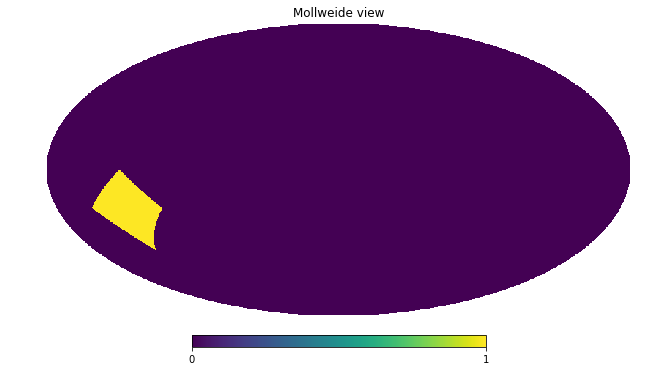

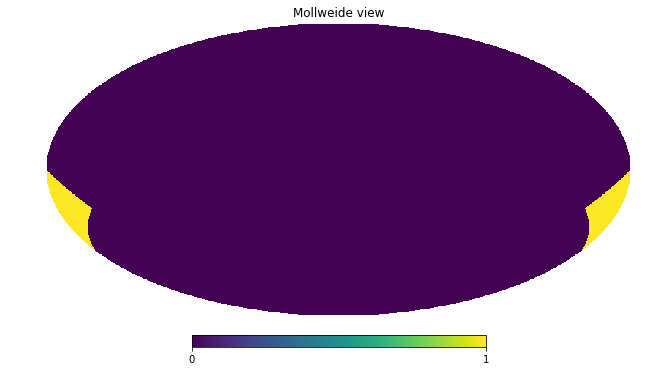

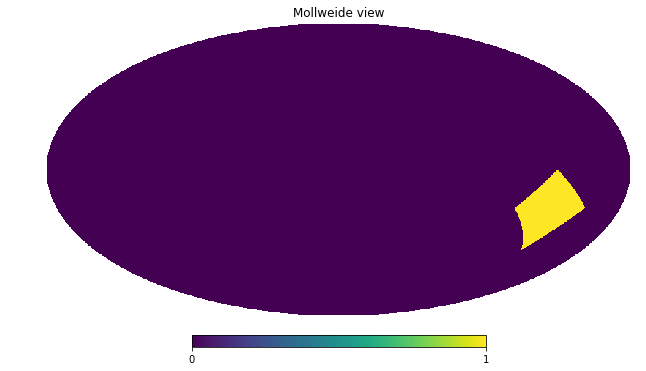

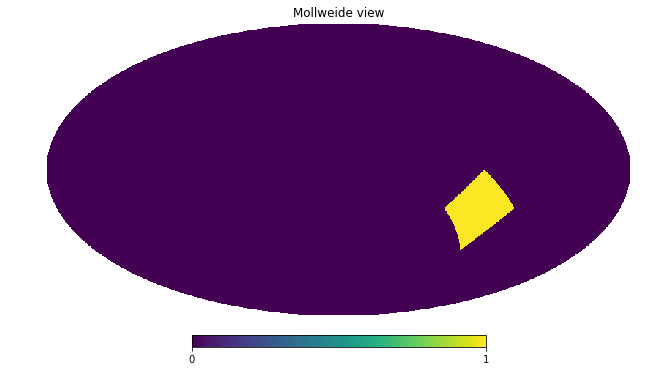

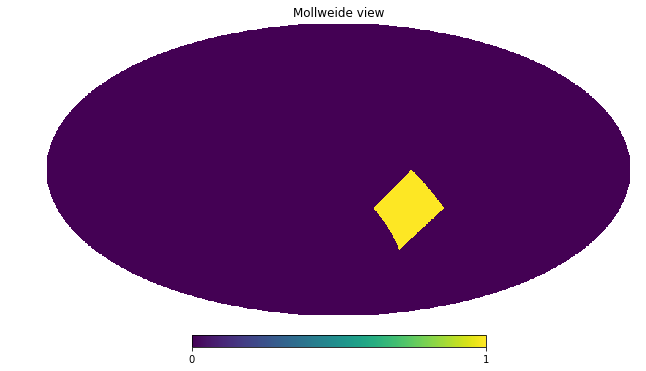

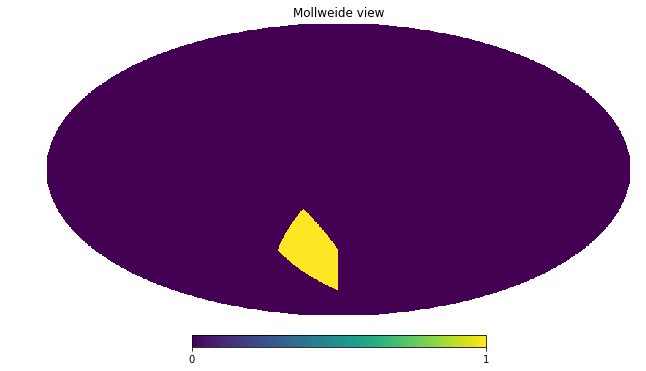

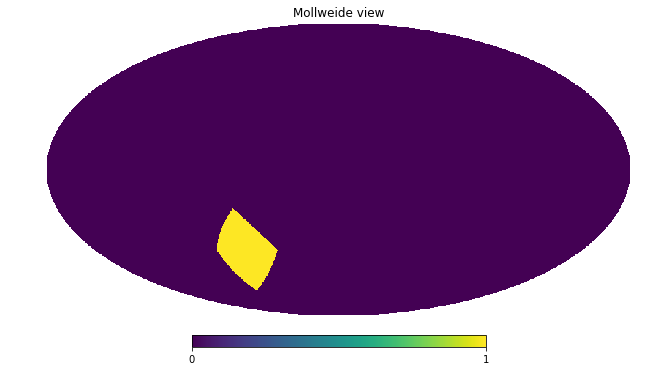

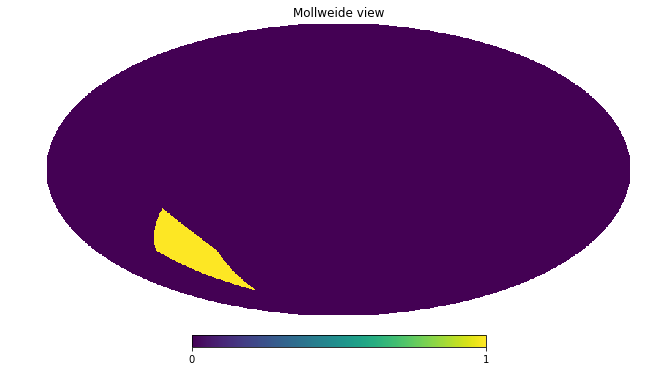

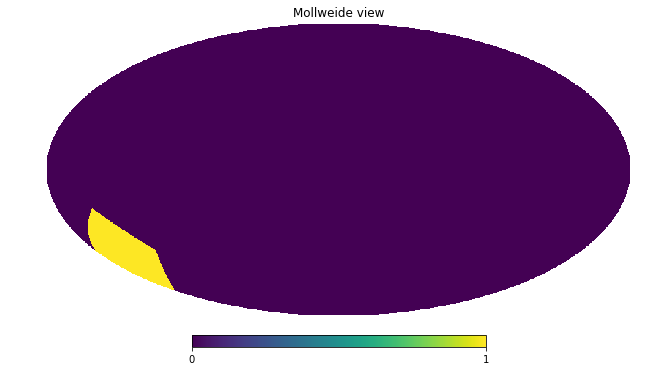

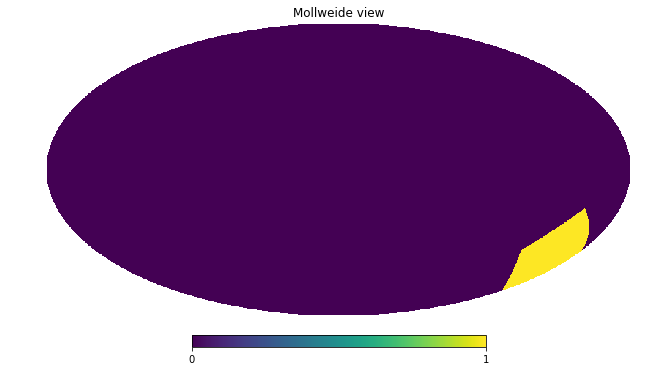

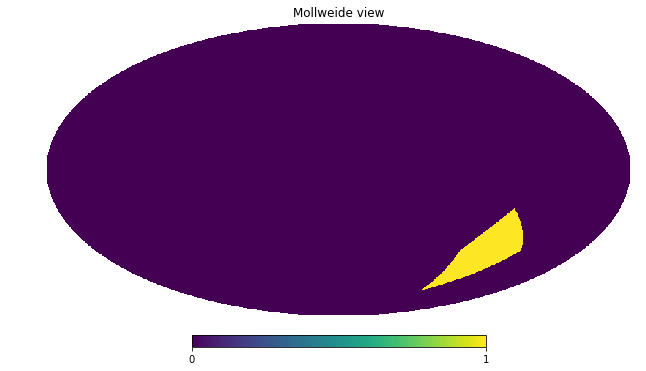

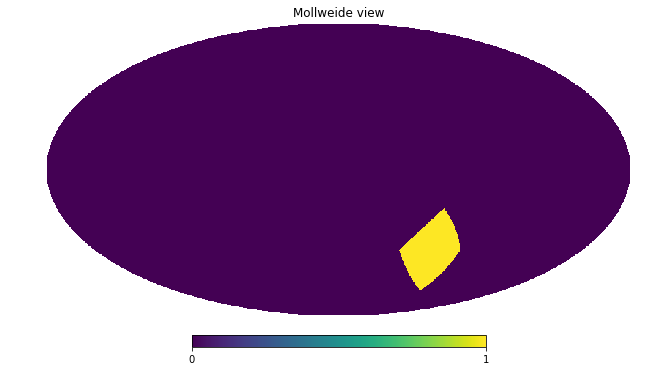

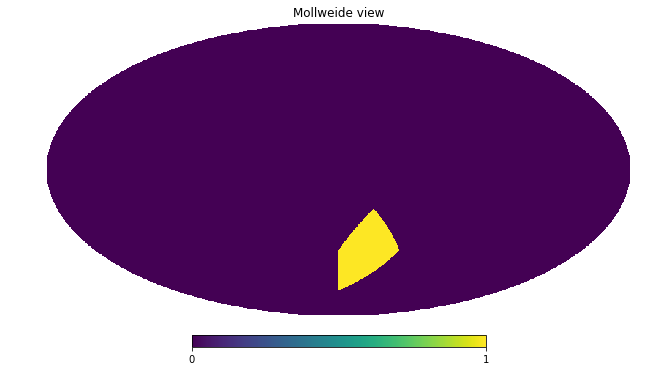

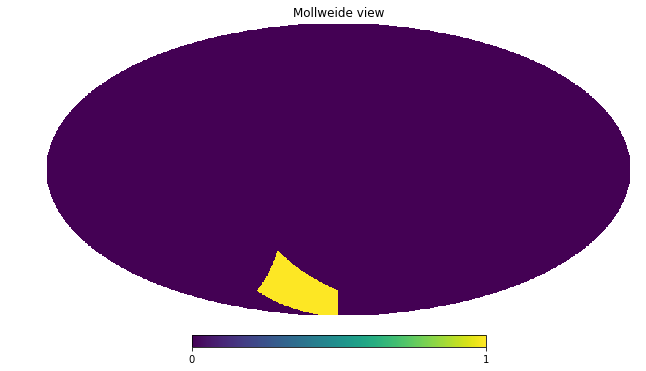

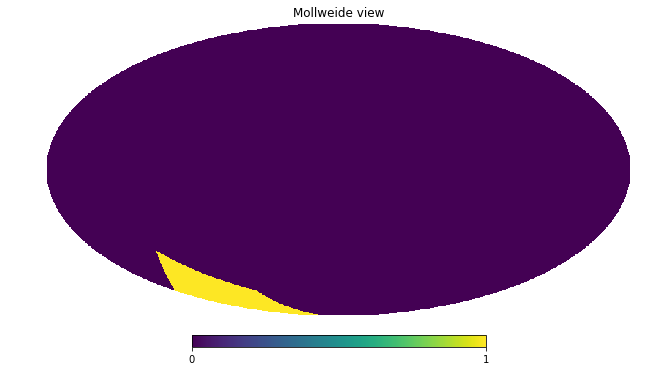

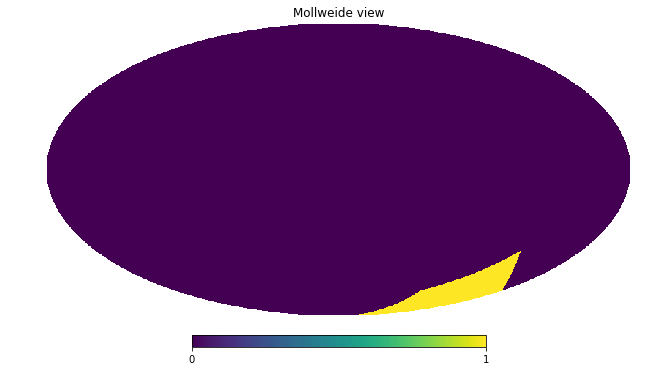

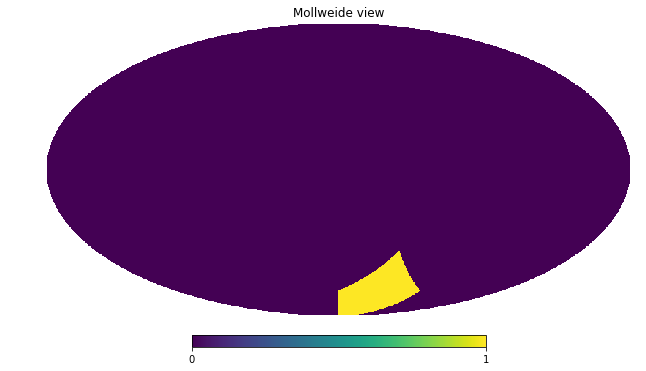

In [21]:
fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
xlim = (-2, 2.5)
ylim = (2, -1)
vmin = 0.01
vmax = 10.0
#loop over pixel on sky
for ax, pixel_index in zip(axes, range(np.max(pixnums)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
        index = (pixnums == pixel_index) & colorCut
        if np.sum(index):
            ax.hist2d(np.log10(data['rad'][index]), np.log10(pm[index].value), bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
            axesnow[0].hist2d(np.log10(data['rad'][index]), np.log10(pm[index].value), bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
        axesnow[0].set_xlim(xlim)
        axesnow[0].set_ylim(ylim)
        mask = np.zeros(npix)
        mask[pixel_index] = 1.0
        map = hp.mollview(mask, return_projected_map=True)
        axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
        axesnow[1].imshow(map, origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
        axesnow[0].set_xlabel('log distance')
        axesnow[0].set_ylabel('log proper motion')
        axesnow[1].set_xlabel('l')
        axesnow[1].set_ylabel('b')
        fignow.savefig('pofd_{0:02d}.pdf'.format(pixel_index), rasterized=True)
for a in axes:
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_xlabel('log d')
    a.set_ylabel('log pm')
fig.savefig('pofd_allStars.pdf')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
axes[nside*3-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.close(fig)
plt.close(fignow)

In [17]:
cmaps = ['Reds', 'Greens', 'Blues']

xbins = np.linspace(-2, 2.5, 51)
ybins = np.linspace(-1, 2, 51)

indices = [allStars, thinDisk, thickDisk, halo, bulge]
indices = [thinDisk, thickDisk, halo]
#loop over type of star
for iPop, fname in zip(indices, filenames):
    fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axes = axes.flatten()
    print np.sum(iPop)
    #loop over axes
    for ax, pixel_index in zip(axes, range(np.max(pixnums)+1)):
        colorInd = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
        pixInd = (pixnums == pixel_index)
        image = np.zeros((len(xbins)-1, len(ybins)-1, 3))
        for i, (cm, app_index) in enumerate(zip(cmaps, indices)):
            magInd = app_index
            index = magInd & pixInd & colorInd
            if np.sum(index):
                hist, xedge, yedge = np.histogram2d(np.log10(pm[index].value), np.log10(data['rad'][index]), 
                                                    bins=[xbins,ybins], normed=True)
                image[:,:,i] = hist 
    for a in axes:
        a.set_xlim(-2, 2.5)
        a.set_ylim(2, -1)
        a.set_xlabel('log d')
        a.set_ylabel('log pm')
    if fname == 'allStars':
        fig.savefig('pofd_' + fname + '.pdf')
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2)
        axes[nside*3-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2)
        fig.savefig('pofd_allStarsLegend.pdf')
    else: fig.savefig('pofd_' + fname +'.pdf')
    plt.close(fig)

NameError: name 'allStars' is not defined

In [ ]:
cmaps = ['Reds', 'Greens', 'Blues']
#plot rgb plot with each color channel a population ie thin disk, thick disk, halo
ybins = np.linspace(-2, 2.5, 51)
xbins = np.linspace(-2, 2.5, 51)
vmin = 0.01

indices = [thinDisk, thickDisk, halo]

fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
axes = axes.flatten()

figTD, axTD = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
axTD = axTD.flatten()
figThD, axThD = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
axThD = axThD.flatten()
figH, axH = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
axH = axH.flatten()

popaxes = [axTD, axThD, axH]

colorInd = (data['sdss_g'] - data['sdss_i']>0.5)  & (data['sdss_g'] - data['sdss_i']<0.75)

#loop over axes
for axI, (ax, pixel_index) in enumerate(zip(axes, range(np.max(pixnums)+1))):
    pixInd = (pixnums == pixel_index)
    image = np.zeros((len(xbins)-1, len(ybins)-1, 4))
    lattice = np.ones((len(xbins)-1, len(ybins)-1))
    for i, (app_index, cm) in enumerate(zip(indices, cmaps)):

        magInd = app_index
        index = magInd & pixInd & colorInd
        if np.sum(index):
            hist, xedge, yedge = np.histogram2d(np.log10(data['rad'][index]), np.log10(pm[index].value),  
                                                    bins=[xbins,ybins])#, normed=True)
            image[:,:,i] = hist 
            testImage = np.zeros((len(xbins)-1, len(ybins)-1, 4))
            testLattice = np.zeros((len(xbins)-1, len(ybins)-1))
            badPixel = hist < vmin
            ax.pcolormesh(x, y, z, cmap=cm, norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))
            #plt.hist(hist, bins=100, log=True)
            testLattice[badPixel] = vmin
            testImage[:,:,i] = hist
            testImage[:,:,3] = testLattice
            popaxes[i][axI].imshow(testImage, origin='lower', extent=(-2, 2.5, -2, 2.5), norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))
    badPixel = np.sum(image[:,:,0:3], axis=2) < vmin
    #print np.sum(badPixe
    lattice[badPixel] = vmin
    image[:,:,3] = lattice
    #ax.imshow(image, origin='lower', extent=(-2, 2.5, -2, 2.5), norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))

for axs in [axes, axTD, axThD, axH]:
    for a in axs:
        a.set_ylim(2.5, -2)
        a.set_xlim(-2, 2.5)
        a.set_ylabel('log pm')
        a.set_xlabel('log d')
figTD.savefig('pofd_ipop_thickdisk.pdf')
figThD.savefig('pofd_ipop_thindisk.pdf')
figH.savefig('pofd_ipop_halo.pdf')
fig.savefig('pofd_ipop.pdf')
plt.close(fig)

In [ ]:
cmaps = ['Reds', 'Greens', 'Blues']
vmin = 0.0001
xbins = np.linspace(-2, 2.5, 21)
ybins = np.linspace(-1, 2, 21)

indices = [allStars, thinDisk, thickDisk, halo, bulge]
indices = [thinDisk, thickDisk, halo]

lowpm = np.log10(pm.value) < 0.5

fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
axes = axes.flatten()

#loop over axes
for ax, pixel_index in zip(axes, range(np.max(pixnums)+1)):
    colorInd = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
    pixInd = (pixnums == pixel_index)
    image = np.zeros((len(xbins)-1, len(ybins)-1, 4))
    lattice = np.ones((len(xbins)-1, len(ybins)-1))
    #for cm, app_index in zip(cmaps, range(np.max(appmagInd) + 1)):
    for i, app_index in enumerate(indices):
        #magInd = (appmagInd == app_index) 
        magInd = app_index
        index = magInd & pixInd & colorInd & lowpm
        if np.sum(index):
            hist, xedge, yedge = np.histogram2d(data['sdss_g'][index], np.log10(data['rad'][index]), 
                                                    bins=[xbins,ybins], normed=True)
            image[:,:,i] = hist #np.log10(hist)
            lattice[hist<vmin] = np.nan
        image[:,:,3] = lattice
        ax.imshow(image, origin='lower', extent=(-2, 2.5, -1, 2), norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))

for a in axes:
    a.set_xlim(-2, 2.5)
    a.set_ylim(2, -1)
    a.set_xlabel('log d')
    a.set_ylabel('log pm')
if fname == 'allStars':
    fig.savefig('pofd_' + fname + '.pdf')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2)
    axes[nside*3-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2)
    fig.savefig('pofd_allStarsLegend.pdf')
else: fig.savefig('pofmagandd.pdf')
plt.close(fig)

In [ ]:
map = hp.mollview(mask, return_projected_map=True)
np.shape(map)

In [ ]:
m = np.arange(hp.nside2npix(nside))
hp.mollview(m, nest=False, title="Mollview image Nest")

In [ ]:
print m
print hp.nside2npix(nside)